In [1]:
%pwd

'e:\\Github Projects\\Retinal_Blood_Vessels_Segmentation\\notebooks'

In [2]:
import sys
sys.path.append("E:\\Github Projects\\Retinal_Blood_Vessels_Segmentation")

In [3]:
import numpy as np

import cv2

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    f1_score,
    precision_score,
    make_scorer
)
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMClassifier, Booster

from imblearn.under_sampling import RandomUnderSampler, NearMiss

from scripts.prepare_data import create_dataset_from_directory, crop_images, create_sliding_window, preprocess_images, get_stats

In [4]:
# crop_images(source_dir="../images/train/img", destination_dir="../cropped_images/train/img")
# crop_images(source_dir="../images/train/mask", destination_dir="../cropped_images/train/mask")
# crop_images(source_dir="../images/test/img", destination_dir="../cropped_images/test/img")
# crop_images(source_dir="../images/test/mask", destination_dir="../cropped_images/test/mask")

X_train, y_train = create_dataset_from_directory(dir="../cropped_images/train",
                                                 channel=1,
                                                 shape=None,
                                                 window_shape=(5, 5),
                                                 pad=True,
                                                 padding=(2, 2),
                                                 sample_size=10000,
                                                 seed=42)

y_train = (y_train/255).astype(int)

Image 1/19
Image 2/19
Image 3/19
Image 4/19
Image 5/19
Image 6/19
Image 7/19
Image 8/19
Image 9/19
Image 10/19
Image 11/19
Image 12/19
Image 13/19
Image 14/19
Image 15/19
Image 16/19
Image 17/19
Image 18/19
Image 19/19


In [5]:
X_train.shape, y_train.shape, np.unique(y_train, return_counts=True)

((190000, 33),
 (190000,),
 (array([0, 1]), array([175772,  14228], dtype=int64)))

In [6]:
undersampler = RandomUnderSampler(random_state=42)
# undersampler = NearMiss()

X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

# del X_train
# del y_train

In [7]:
X_undersampled.shape, y_undersampled.shape, np.unique(y_undersampled, return_counts=True)

((28456, 33), (28456,), (array([0, 1]), array([14228, 14228], dtype=int64)))

In [8]:
def specificity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)


# pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
#                            ('clf', RandomForestClassifier(n_estimators=30, random_state=42))])

# pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
#                            ('clf', KNeighborsClassifier(n_neighbors=10))])

# pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
#                            ('clf', LGBMClassifier(objective='binary', scale_pos_weight=0.5, random_state=42))])

model = LGBMClassifier(objective='binary', scale_pos_weight=0.5, random_state=42)

scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'specificity': make_scorer(specificity)
}

cv_res = cross_validate(model,
                        X_undersampled,
                        y_undersampled,
                        cv=4,
                        scoring=scoring)

In [9]:
cv_res['test_f1'].mean(), cv_res['test_accuracy'].mean(), cv_res['test_precision'].mean(), cv_res['test_recall'].mean(), cv_res['test_specificity'].mean()

(0.7791277821485891,
 0.7985310655046387,
 0.8570064312840893,
 0.7159825695811076,
 0.8810795614281698)

In [10]:
model.fit(X_undersampled, y_undersampled)

LGBMClassifier(objective='binary', random_state=42, scale_pos_weight=0.5)

In [11]:
def prepare_image(image: np.ndarray, channel=1, window_shape=(5, 5), pad=True, padding=(2, 2)) -> np.ndarray:        
    preprocessed_img = preprocess_images([image], channel)
    windows = create_sliding_window(*preprocessed_img, window_shape, pad, padding)
    img_stats = [get_stats(window) for window in windows]

    X = []

    for window, stats in zip(windows, img_stats):
        # X.append(np.hstack((window.flatten(), stats)))
        X.append(stats)
    
    return X

In [12]:
def plot_prediction(true_img: np.ndarray, true_mask: np.ndarray, pred: np.ndarray) -> None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 2)
    plt.title("True mask")
    plt.imshow(true_mask, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred, cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.show()

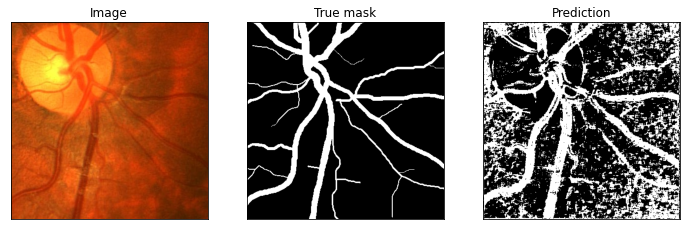

In [13]:
test_img = cv2.imread("../cropped_images/train/img/Image_01R.jpg")
test_mask = cv2.imread("../cropped_images/train/mask/Image_01R_1stHO.png", cv2.IMREAD_GRAYSCALE)

x_start, x_end = (400, 800)
y_start, y_end = (400, 800)

x_size = x_end - x_start
y_size = y_end - y_start

cropped_image = test_img[x_start : x_end, y_start : y_end]
cropped_mask = test_mask[x_start : x_end, y_start : y_end]
prepared_img = prepare_image(cropped_image)

img_pred = model.predict(prepared_img)

plot_prediction(cropped_image, cropped_mask, img_pred.reshape(x_size, y_size))

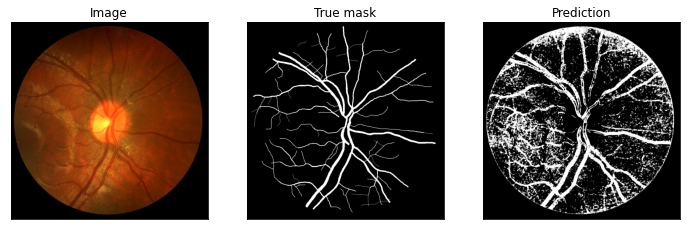

In [14]:
test_img = cv2.imread("../cropped_images/test/img/Image_10R.jpg")
test_mask = cv2.imread("../cropped_images/test/mask/Image_10R_1stHO.png", cv2.IMREAD_GRAYSCALE)

x_start, x_end = (0, 959)
y_start, y_end = (0, 959)

x_size = x_end - x_start
y_size = y_end - y_start

cropped_image = test_img[x_start : x_end, y_start : y_end]
cropped_mask = test_mask[x_start : x_end, y_start : y_end]
prepared_img = prepare_image(cropped_image)

img_pred = model.predict(prepared_img)
img_pred_binarized = np.where(img_pred > 0.5, 1, 0)

plot_prediction(cropped_image, cropped_mask, img_pred_binarized.reshape(x_size, y_size))

In [15]:
model.booster_.save_model('../models/lgbm.txt')